In [1]:
### Set up
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse
)
import polars as pl
import torch
import functorch


from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.permutations import Permutation, make_permutation_dataset, generate_subgroup
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

In [2]:

def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs

In [22]:
exp_dir = Path('experiments')
model_seed = 4
data_seed = 11
run_name = f'model_{model_seed}_data_{data_seed}'
run_dir = exp_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
loss = model_run['test_loss']
data = pl.read_parquet(exp_dir / f'data_{data_seed}.parquet')
lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

out, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(out, targets)

linear_acts = cache['hook_linear']

In [23]:
def comma_sep(x):
    return "(" + ", ".join([i for i in x]) + ")"


linear_acts_df = pl.concat(
    [
        data.with_columns([
            pl.col('permutation_left').apply(lambda x: comma_sep(x)),
            pl.col('permutation_right').apply(lambda x: comma_sep(x)),
            pl.col('permutation_target').apply(lambda x: comma_sep(x))

        ]),
        pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])
    ],
    how='horizontal'
)

linear_acts_df.head()



permutation_left,permutation_right,permutation_target,index_left,index_right,index_target,in_train,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,i32,i32,i32,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",0,0,0,0,-2.284954,-4.513199,-0.012378,6.462366,2.247239,5.349617,7.663986,0.000282,3.227232,-0.865692,2.551223,0.517381,-6.140494,-5.40687,4.198558,-4.358971,-3.846363,-4.126196,-6.294382,3.717979,-1.927634,-5.305726,0.002113,4.407357,3.57938,-2.182353,6.966483,0.699072,-6.485773,7.667966,...,0.054176,-2.270312,2.46847,-2.583997,0.134056,-7.598335,-3.573524,3.883464,3.291476,0.038526,2.166231,2.247754,-1.588019,-3.526042,-4.644562,-4.878227,1.372549,-4.068241,-2.693088,6.062502,2.393129,-4.188018,-6.742337,1.337838,5.893494,2.415468,-0.000987,-0.593564,2.36868,-5.470556,-2.064901,2.956321,-1.199175,-4.372405,0.374796,-0.269887,-1.984549
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",0,1,1,1,-8.541143,-5.986142,8.14264,4.849241,4.428206,-1.181159,7.601687,6.121847,1.599453,-0.586614,2.786988,0.000071,-6.437174,-3.565777,5.071635,5.14327,-3.20936,-2.693769,-4.7244,3.701089,0.548052,-6.351729,-8.320764,2.759737,-0.133277,2.647249,4.828623,3.758186,-0.401118,-3.425503,...,-4.5713,0.106816,2.444396,-2.555292,0.133994,3.398278,-3.567442,0.457434,3.177427,-0.428895,-2.62203,0.489158,-1.339338,1.355721,-5.75676,0.012436,3.526459,0.273068,0.134907,0.106896,-0.398394,-2.626446,-6.91699,-0.700832,3.297025,4.331966,-0.00077,-4.542743,-0.032251,-5.239071,4.140011,3.76998,-0.946303,-3.856384,2.618052,5.147303,-1.985569
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",0,2,2,1,-3.449136,-6.360678,3.781724,-0.001018,-1.625634,3.29231,7.681121,4.593587,-3.306748,-0.780348,2.946697,-2.957624,-4.935564,-0.167646,6.617008,0.000739,0.396048,0.13543,-0.000352,3.701482,-2.326522,-4.733948,-3.84481,-2.204198,5.785414,-1.276657,2.302552,3.916304,-4.016205,2.573144,...,-3.235384,0.447183,2.444407,-2.574824,0.134229,-2.546784,-3.571997,-0.015779,3.309667,-3.513183,1.26764,2.27427,-1.76581,-2.60793,-4.464861,-5.932156,1.891951,-6.342594,-1.551385,4.244009,2.738891,2.084901,-7.07511,-3.159458,0.911766,4.701688,-0.000021,-4.806919,-0.670786,-5.539081,2.589196,2.155295,-0.721847,-4.583164,0.265641,1.532634,-1.984472
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",0,3,3,0,-5.091905,-1.972687,8.142116,6.461438,-1.34138,2.694483,7.664136,7.688538,3.223861,0.321284,5.369231,0.042553,-6.119217,-4.157574,4.975049,5.143779,-4.514254,-3.448701,-6.295137,2.077526,-2.251324,-4.610642,-8.317357,4.405457,5.842899,0.001712,-0.038354,3.420693,-5.678736,-3.428533,...,-5.544862,-2.216644,3.086726,-3.182167,-6.386033,3.395353,-2.00902,3.05225,3.489932,-0.439445,-0.000426,2.760795,3.070669,-1.308727,-3.953059,0.011871,-2.267303,-6.319485,-2.133198,5.256571,2.457617,-4.189132,-5.760373,-5.536029,-2.305743,0.162766,-0.000947,-3.526889,2.291042,0.014821,5.724225,1.312839,-1.074554,-4.609921,0.018647,3.841383,-1.984026
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",0,4,4,0,-6.822788,-0.485496,-0.011225,0.004157,4.283764,2.651156,7.534682,2.038142,-3.306458,4.005553,3.153524,0.509131,-1.906183,-3.912105,4.388658,-4.357673,-3.36435,0.507606,-0.001175,-2.779725,0.655657,-5.978425,0.001733,-2.20373,-0.126537,1.308678,-0.068529,0.724247,-5.45

In [24]:
frobenius_groups = {
        "order": 20,
        "copies": 6,
        "generators": [
            [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
            [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
            [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
            [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
            [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
            [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
        ]
    
}

In [25]:
f1 = generate_subgroup(frobenius_groups['generators'][1])

In [26]:
S5 = Permutation.full_group(5)
all_s5 = set([s.sigma for s in S5])

In [27]:
frob = [Permutation(s) for s in f1]


In [28]:
from functools import reduce

def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets
        
        
    
s3_x_s2 = {
        "order": 12,
        "copies": 10,
        "generators": [
            [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4), (1, 0, 2, 3, 4)], #1
            [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3), (2, 1, 0, 3, 4)], #2
            [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4), (3, 1, 2, 0, 4)], #3
            [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4), (4, 1, 2, 3, 0)], #4
            [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4), (0, 2, 1, 3, 4)], #5
            [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4), (0, 3, 2, 1, 4)], #6
            [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4), (0, 4, 2, 3, 1)], #7
            [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4), (0, 1, 3, 2, 4)], #8
            [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4), (0, 1, 4, 3, 2)], #9
            [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4), (0, 1, 2, 4, 3)], #10
        ]
    
    }

In [29]:
sg = generate_subgroup([(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)])
print(sg)
print([Permutation(p).parity for p in sg])


[(4, 1, 0, 3, 2), (1, 4, 2, 3, 0), (2, 1, 4, 3, 0), (4, 2, 1, 3, 0), (0, 2, 4, 3, 1), (0, 4, 1, 3, 2), (1, 0, 4, 3, 2), (1, 2, 0, 3, 4), (4, 0, 2, 3, 1), (0, 1, 2, 3, 4), (2, 4, 0, 3, 1), (2, 0, 1, 3, 4)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [30]:
generate_subgroup(s3_x_s2["generators"][2])

[(3, 1, 2, 0, 4),
 (0, 1, 4, 3, 2),
 (3, 1, 4, 0, 2),
 (0, 2, 4, 3, 1),
 (0, 2, 1, 3, 4),
 (0, 4, 1, 3, 2),
 (3, 4, 2, 0, 1),
 (0, 4, 2, 3, 1),
 (3, 2, 4, 0, 1),
 (3, 2, 1, 0, 4),
 (3, 4, 1, 0, 2),
 (0, 1, 2, 3, 4)]

In [31]:
f2_cosets = get_cosets(generate_subgroup(frobenius_groups['generators'][2]))

In [32]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def embedding_harmonic_analysis(checkpoint):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(checkpoint['config'])
    model.load_state_dict(checkpoint['model'])
    epoch = checkpoint['checkpoint_epochs'][-1]
    
    #out, cache = model.run_with_cache(lperms[test_mask], rperms[test_mask])
    #loss = loss_fn(out, targets[test_mask])
    
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight, 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight, 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return pl.concat([lembed_power_df, rembed_power_df], how='vertical'), lembed_fourier_transform, rembed_fourier_transform

In [33]:

W = model.linear.weight
lperm = model.lembed.weight[0, :]
rperm = model.rembed.weight[1, :]
torch.allclose(W @ torch.concat([lperm, rperm]), cache['hook_linear'])

False

In [34]:
W[:, :256] @ lperm

tensor([-4.3634, -3.1092,  3.9651,  4.1385,  1.2420,  1.0720,  3.8499,  3.9216,
         0.8796,  2.4842,  1.2934, -1.1582, -3.1900, -2.4035,  3.1903,  0.2585,
        -1.6420, -1.4530, -4.0309,  1.8409, -0.8786, -3.1002, -4.0526,  2.0305,
         2.6626, -0.5734,  3.5406,  1.6717, -2.7689,  2.2777,  0.9442,  2.0159,
         0.5868,  1.0824, -1.4618,  2.0110, -1.7038, -3.0868, -1.1943,  1.2836,
        -3.2874, -2.3418,  1.1117,  3.5432,  1.9893, -0.9329, -0.0947,  2.8087,
        -1.1101, -2.2668, -1.4680,  3.1954,  2.6595,  0.3638,  1.9873,  2.1331,
        -2.2944,  1.3419,  2.0513,  1.7007,  2.8753, -1.0873, -1.1440, -2.9882,
         3.3807, -1.5658, -2.4640,  2.5768, -1.1135, -1.4386, -0.8489,  2.5931,
         1.8593, -2.3508, -3.2071,  1.5758, -1.1640, -0.2111,  1.1602,  1.1626,
        -0.2791,  1.9650,  0.8609,  3.2552,  1.8405, -3.8446,  1.0156, -1.9234,
        -1.9564,  2.7519,  0.8054, -2.9015, -1.0147,  1.4902, -1.5766, -3.2228,
        -2.2542, -1.7770,  1.6861,  1.32

In [35]:
torch.allclose((W[:, :256] @ model.lembed.weight.T)[:, 0], W[:, :256] @ lperm)

True

In [36]:
llin_ft = slow_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)

In [37]:
(model.lembed.weight @ W[:, :256].T)

tensor([[-4.3634, -3.1092,  3.9651,  ...,  1.4061,  2.1672, -0.2300],
        [ 0.7278, -2.7927,  0.1793,  ..., -1.5294, -1.6690,  4.4043],
        [ 2.4600, -1.3680, -4.1774,  ...,  0.8399, -0.6516, -4.1573],
        ...,
        [ 0.7367, -1.0291,  0.1835,  ..., -0.8974, -1.6739,  1.7541],
        [-0.9102,  2.5484, -1.6856,  ...,  1.4260,  0.6381, -1.7671],
        [-2.0771, -1.5463,  1.7083,  ...,  1.0043,  2.4372, -0.2318]],
       grad_fn=<MmBackward0>)

In [38]:
llin_ft[(1, 1, 1, 1, 1)].shape[0]

128

In [39]:
def ft_to_block_diag(ft, index):
    blocks = []
    for k, mat in ft.items():
        dim = mat.shape[1] if mat.dim() > 1 else 1
        blocks.extend([mat[index] for _ in range(dim)])
    return torch.block_diag(*blocks)
        
ft_to_block_diag(llin_ft, 0)

tensor([[ 0.2867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0091, -0.0220,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0368, -0.0147,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0035,  0.0011,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0402,  0.0363,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0107]],
       grad_fn=<BlockDiagBackward0>)

In [40]:
rlin_ft[(2, 1, 1, 1)][4] @ llin_ft[(2, 1, 1, 1)][4] 

tensor([[ 0.5055,  0.2286,  0.4491, -1.2309],
        [ 0.8002,  0.1534,  1.0744,  0.3098],
        [-0.7681, -0.1502, -1.6380,  1.2988],
        [ 0.2185,  0.2094,  0.0806, -1.6753]], grad_fn=<MmBackward0>)

In [41]:
rlin_ft[(5,)].dim()

1

In [42]:
from functorch import vmap


def ft_convolve(f, g):
    out = {}
    for key, m1 in f.items():
        m2 = g[key]
        if m1.dim() == 1:
            prod = m1 * m2
        else:
            prod = torch.bmm(m1, m2)
        out[key] = prod
    return out


sn_fourier_basis(ft_convolve(llin_ft, rlin_ft), 5)

tensor([[[-4.2935e-04,  1.8960e-03, -2.5552e-04,  ..., -2.0027e-02,
          -1.6427e-02, -4.7098e-06],
         [-1.8002e-05,  5.8905e-02, -9.3410e+02,  ..., -2.3239e-03,
          -1.7260e-04,  2.5767e+02],
         [ 4.4415e-05, -2.8094e-02,  1.7037e-03,  ...,  5.9320e+01,
          -6.0394e-05,  2.6534e-06],
         ...,
         [ 1.9265e+02,  4.9824e-02,  1.8456e-03,  ...,  3.6524e-02,
           9.2271e+01,  7.0840e-06],
         [-2.0365e-05, -8.5751e+01,  3.2785e-04,  ..., -6.0043e-03,
           6.2900e-04,  2.1073e-07],
         [-2.7792e-06, -4.7676e+00,  9.5192e-06,  ..., -3.3483e-03,
          -4.9023e-05,  2.1687e-06]],

        [[-4.2935e-04,  1.8960e-03, -2.5552e-04,  ..., -2.0027e-02,
          -1.6427e-02, -4.7098e-06],
         [-1.7689e-05,  7.3314e-02,  2.3134e+02,  ...,  3.5298e-01,
          -2.9888e-05,  2.5771e+02],
         [-4.3392e-05,  6.5811e-02, -1.6485e-03,  ..., -5.9567e+01,
           8.2585e-05,  2.7665e-05],
         ...,
         [ 1.9271e+02,  1

In [43]:

def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')

In [44]:
convolved_fn = sn_fourier_basis(ft_convolve(llin_ft, rlin_ft), 5) / 120
conv_df = fourier_basis_to_df(convolved_fn, 5)

In [45]:
convolved_fn.sum(dim=1)

tensor([[ 1.6054, -0.7541, -7.7841,  ...,  0.4945,  0.7688,  2.1472],
        [ 1.6059, -0.5930,  1.9278,  ..., -0.4939,  0.7731,  2.1476],
        [ 1.6088,  3.4477,  1.9575,  ..., -0.4454,  0.7742,  2.1466],
        ...,
        [ 1.6091,  0.9028,  1.9511,  ...,  0.5024,  0.7675, -8.5872],
        [ 1.6098,  0.8144,  1.9532,  ...,  0.5055,  0.7713,  2.1454],
        [-8.0387,  5.1402,  1.9524,  ..., -1.4765, -3.8544,  2.1476]],
       grad_fn=<SumBackward1>)

In [46]:
conv_df.head(7)

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.000004,0.000016,-0.000002,-0.000003,0.000001,-9.4994e-8,-0.000015,-0.000002,-0.000003,-0.000004,0.000096,-0.000021,0.000077,0.000174,-0.000012,1.1531e-7,-0.00001,-0.000363,-0.000003,2.9082e-7,0.000009,0.000032,-0.000004,-0.000003,-0.000021,-0.000007,-0.00004,0.00025,-0.000029,5.2860e-7,-0.000003,-0.000083,0.000003,-0.000023,-0.000242,...,0.000142,0.000007,0.000042,0.000008,-0.000132,-8.5838e-8,3.1931e-9,0.000033,-0.000002,0.000006,-0.000004,-0.000029,0.000145,-0.000012,-0.000006,-0.000579,-0.000104,-0.000115,0.000034,0.000031,0.000008,-0.000003,-0.000127,-0.000108,-0.00045,0.00012,1.5588e-7,-0.000439,0.000008,0.00002,-0.000002,-0.000146,-0.000016,0.000114,-0.000167,-0.000137,-3.9248e-8
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-1.5002e-7,0.000491,-7.784177,-8.6201e-8,-0.000737,0.001186,0.000743,3.7167e-8,-2.1779e-8,-0.001008,-0.002611,-0.000765,-0.009642,0.000042,0.000013,2.642415,-0.000082,-0.000823,2.6009e-8,2.364946,-0.000864,-0.000106,-8.092562,-8.6934e-8,-0.00041,-0.000004,-0.00176,-0.001057,0.000955,3.613302,-1.1843e-7,0.000251,0.001092,-0.000459,0.000709,...,0.001366,-0.001305,0.005698,0.00592,-0.000236,3.541869,2.208927,0.00283,-0.000973,-0.00298,0.000005,0.000686,-0.001893,-0.000002,-0.000365,1.101876,0.001677,0.000572,-0.001577,-0.000503,-0.001394,-2.1554e-7,0.001168,-0.000035,0.000505,0.003871,-12.05185,-0.000953,0.001116,-0.000591,-6.4494e-9,0.000005,0.000285,0.001376,-0.000019,-0.000001,2.147232
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",3.7012e-7,-0.000234,0.000014,-4.5115e-8,0.000165,-0.000579,0.000115,2.3792e-8,-2.3728e-7,0.000736,-0.000849,0.668506,0.000427,0.000508,0.000212,0.000001,-0.000489,0.000395,-2.4377e-8,3.8758e-7,0.526531,-0.000135,0.000004,1.5823e-7,-0.000687,0.000012,0.000738,0.001337,0.000445,7.7195e-7,2.3586e-7,-0.000405,0.000083,0.601564,-0.000778,...,-0.011354,0.913611,-0.558083,-0.565518,-0.000311,0.000001,0.000002,2.194719,0.001699,-2.124958,0.000007,-0.002343,-0.004237,-0.000004,-0.000504,-0.00008,-0.001132,-0.000037,0.015914,-0.001174,-0.565058,2.4228e-7,-0.00036,0.00031,-0.001569,0.00017,5.8868e-7,0.001435,-0.450159,0.000733,-2.2820e-8,-0.000002,0.000617,0.000158,0.494333,-5.0329e-7,2.2112e-8
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",-7.8152e-9,-0.000444,0.000009,-3.5130e-8,0.000141,-0.000475,-0.000042,-1.2523e-8,-1.8485e-7,-0.000479,-0.000192,-0.000033,-0.000485,0.003154,-0.000243,5.2303e-7,-0.001851,-0.002464,1.5613e-7,3.2774e-7,-0.000052,-0.000334,0.00001,-3.7955e-8,0.000684,-0.000008,0.001563,0.000144,0.000603,-3.3879e-7,1.6805e-7,0.000469,0.000177,0.000036,-0.000601,...,0.0006,0.000118,-0.000339,-0.000287,0.00014,-2.0310e-7,6.2192e-7,0.000038,-0.002365,0.000159,0.000026,-0.000687,-0.000229,0.000002,-0.00043,0.000009,0.001581,-0.000059,0.000298,-0.000937,0.00032,-3.1321e-7,-0.000457,-0.00068,-0.001834,-0.000901,-0.000001,0.001463,-0.00009,-0.000549,7.6857e-9,0.000002,0.000166,-0.003309,0.000118,-0.000002,-3.1186e-8
"""(0, 1, 2, 3, 4...","""(3, 2)""",1.605383,0.000415,0.000015,1.451233,-0.000604,-0.001117,-0.000282,-6.515632,1.484117,0.000206,0.001936,-0.000046,-0.001983,-0.001673,0.000639,-4.5411e-7,0.002551,0.001669,1.375965,-0.000001,0.00048,-0.000205,-0.000002,1.519369,-0.003302,0.953227,-

In [137]:
from functools import reduce

def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, prefix):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), f'coset_rep_{prefix}': rep} for c in cos])
    return pl.DataFrame(data)



def make_coset_rep_df(generators):
    data = []
    
    for i, g in enumerate(generators):
        cosets = list(get_cosets(generate_subgroup(g)))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)


#f2_cosets = get_cosets(generate_subgroup(frobenius_groups['generators'][2]))

#f1_df = make_coset_rep_df(list(f1_cosets))
#f2_df = make_coset_rep_df(list(f2_cosets))

frob_cosets = make_coset_rep_df(frobenius_groups['generators'])

In [48]:
s4_subgroups = {
        "order": 12,
        "copies": 5,
        "generators": [
            [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
            [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
            [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
            [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
            [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
        ]
    }


s3_subgroups = {
        "order": 6,
        "copies": 10,
        "generators": [
            [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4)], #1  fix 0 1
            [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3)], #2  fix 0 2
            [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4)], #3  fix 0 3
            [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4)], #4  fix 0 4
            [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4)], #5  fix 1 2
            [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4)], #6  fix 1 3
            [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4)], #7  fix 1 4
            [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4)], #8  fix 2 3
            [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4)], #9  fix 2 4
            [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4)], #10 fix 3 4
        ]
    }

a4_subgroups = {
        "order": 12,
        "copies": 5,
        "generators": [
            [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
            [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
            [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
            [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
            [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

        ]
    }

s3_cosets = make_coset_rep_df(s3_subgroups['generators'])
s4_cosets = make_coset_rep_df(s4_subgroups['generators'])
s3xs2_cosets = make_coset_rep_df(s3_x_s2['generators'])
a4_cosets = make_coset_rep_df(a4_subgroups['generators'])

In [49]:
s3xs2_cosets.head()

permutation,coset_rep_0,coset_rep_1,coset_rep_2,coset_rep_3,coset_rep_4,coset_rep_5,coset_rep_6,coset_rep_7,coset_rep_8,coset_rep_9
str,str,str,str,str,str,str,str,str,str,str
"""(3, 0, 1, 4, 2...","""(2, 0, 1, 3, 4...","""(1, 0, 3, 4, 2...","""(0, 3, 1, 2, 4...","""(1, 0, 2, 4, 3...","""(0, 3, 1, 4, 2...","""(1, 0, 3, 2, 4...","""(0, 2, 1, 4, 3...","""(2, 0, 1, 4, 3...","""(0, 1, 3, 2, 4...","""(3, 0, 1, 4, 2..."
"""(3, 0, 2, 4, 1...","""(2, 0, 3, 4, 1...","""(1, 0, 2, 3, 4...","""(0, 3, 1, 2, 4...","""(1, 0, 2, 4, 3...","""(0, 3, 1, 4, 2...","""(1, 0, 2, 4, 3...","""(0, 2, 3, 1, 4...","""(2, 0, 3, 1, 4...","""(0, 1, 2, 4, 3...","""(3, 0, 1, 4, 2..."
"""(3, 1, 0, 4, 2...","""(2, 0, 1, 3, 4...","""(1, 3, 0, 4, 2...","""(0, 1, 3, 2, 4...","""(1, 2, 0, 4, 3...","""(0, 1, 3, 4, 2...","""(1, 3, 0, 2, 4...","""(0, 1, 2, 4, 3...","""(2, 0, 1, 4, 3...","""(0, 1, 3, 2, 4...","""(3, 0, 1, 4, 2..."
"""(3, 1, 2, 4, 0...","""(2, 0, 3, 4, 1...","""(1, 3, 0, 4, 2...","""(0, 1, 2, 4, 3...","""(1, 2, 3, 0, 4...","""(0, 1, 2, 3, 4...","""(1, 3, 0, 2, 4...","""(0, 1, 2, 4, 3...","""(2, 0, 3, 1, 4...","""(0, 1, 2, 4, 3...","""(3, 0, 1, 4, 2..."
"""(3, 2, 0, 4, 1...","""(2, 3, 0, 4, 1...","""(1, 0, 2, 3, 4...","""(0, 1, 3, 2, 4...","""(1, 2, 0, 4, 3...","""(0, 1, 3, 4, 2...","""(1, 0, 2, 4, 3...","""(0, 2, 3, 1, 4...","""(2, 3, 0, 1, 4...","""(0, 2, 1, 4, 3...","""(3, 0, 1, 4, 2..."


In [50]:
frob_analysis = (
    conv_df
    .join(frob_cosets, on='permutation', how='inner')
    .melt(id_vars=['permutation', 'coset_rep_0', 'coset_rep_1', 'coset_rep_2', 'coset_rep_3', 'coset_rep_4', 'coset_rep_5', 'irrep'])
)
frob_analysis.head()

s4_analysis = (
    conv_df
    .join(s4_cosets, on='permutation', how='inner')
    .melt(id_vars=['permutation', 'coset_rep_0', 'coset_rep_1', 'coset_rep_2', 'coset_rep_3', 'coset_rep_4', 'irrep'])
)

a4_analysis = (
    conv_df
    .join(a4_cosets, on='permutation', how='inner')
    .melt(id_vars=['permutation', 'coset_rep_0', 'coset_rep_1', 'coset_rep_2', 'coset_rep_3', 'coset_rep_4', 'irrep'])
)

s3_analysis = (
    conv_df
    .join(s3_cosets, on='permutation', how='inner')
    .melt(id_vars=[
        'permutation', 
        'coset_rep_0',
        'coset_rep_1',
        'coset_rep_2',
        'coset_rep_3',
        'coset_rep_4',
        'coset_rep_5',
        'coset_rep_6', 
        'coset_rep_7',
        'coset_rep_8',
        'coset_rep_9',
        'irrep'])
)

s3xs2_analysis = (
    conv_df
    .join(s3xs2_cosets, on='permutation', how='inner')
    .melt(id_vars=[
        'permutation', 
        'coset_rep_0',
        'coset_rep_1',
        'coset_rep_2',
        'coset_rep_3',
        'coset_rep_4',
        'coset_rep_5',
        'coset_rep_6', 
        'coset_rep_7',
        'coset_rep_8',
        'coset_rep_9',
        'irrep'])
)

In [176]:
dim0_df = (
    linear_acts_df
    .select(pl.all().exclude('in_train'))
    .select(pl.all().exclude('^index.*$'))
    #.join(frob_cosets.melt(id_vars='permutation', variable_name='coset', value_name='coset_rep'), left_on='permutation_target', right_on='permutation' , how='inner')
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .filter(pl.col('variable') == 'dim0')
    #.select(pl.all().exclude('variable'))
    #.filter(pl.col('value') >= 0)
    #.with_columns((pl.col('value') * (pl.col('value') > 0.).cast(pl.Float32)).alias('relu_value'))
    #.groupby('permutation_target')
    #.agg([
    #    pl.col('value').min().alias('min_value'),
    #    pl.col('value').mean().alias('mean_value'),
    #    pl.col('value').std().alias('std_value'),
    #    pl.col('value').max().alias('max_value')
    #
    #])
    #.filter(pl.col('value').abs() > 8.5)
    .sort(['permutation_target', 'permutation_left', 'permutation_right', 'value'])
)
dim0_df.head(20)

permutation_left,permutation_right,permutation_target,variable,value
str,str,str,str,f32
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""dim0""",-2.284954
"""(0, 1, 2, 4, 3...","""(0, 1, 2, 4, 3...","""(0, 1, 2, 3, 4...","""dim0""",2.288659
"""(0, 1, 3, 2, 4...","""(0, 1, 3, 2, 4...","""(0, 1, 2, 3, 4...","""dim0""",-1.642533
"""(0, 1, 3, 4, 2...","""(0, 1, 4, 2, 3...","""(0, 1, 2, 3, 4...","""dim0""",1.642133
"""(0, 1, 4, 2, 3...","""(0, 1, 3, 4, 2...","""(0, 1, 2, 3, 4...","""dim0""",-1.717719
"""(0, 1, 4, 3, 2...","""(0, 1, 4, 3, 2...","""(0, 1, 2, 3, 4...","""dim0""",1.716778
"""(0, 2, 1, 3, 4...","""(0, 2, 1, 3, 4...","""(0, 1, 2, 3, 4...","""dim0""",-3.449362
"""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...","""(0, 1, 2, 3, 4...","""dim0""",3.448436
"""(0, 2, 3, 1, 4...","""(0, 3, 1, 2, 4...","""(0, 1, 2, 3, 4...","""dim0""",6.823898


In [165]:
left_pos = (
    dim0_df
    .groupby('permutation_left')
    .agg(pl.col('value').mean())
    .sort('permutation_left').filter(pl.col('value') > 0)['permutation_left'].to_list()
)
left_neg =  (
    dim0_df
    .groupby('permutation_left')
    .agg(pl.col('value').mean())
    .sort('permutation_left').filter(pl.col('value') < 0)['permutation_left'].to_list()
)

right_pos = (
    dim0_df
    .groupby('permutation_right')
    .agg(pl.col('value').mean())
    .sort('permutation_right').filter(pl.col('value') > 0)['permutation_right'].to_list()
)
right_neg =  (
    dim0_df
    .groupby('permutation_right')
    .agg(pl.col('value').mean())
    .sort('permutation_right').filter(pl.col('value') < 0)['permutation_right'].to_list()
)


left_pos = tuple([eval(p) for p in left_pos])
left_neg = tuple([eval(p) for p in left_neg])
right_pos = tuple([eval(p) for p in right_pos])
right_neg = tuple([eval(p) for p in right_neg])


In [166]:
#dim0_df.groupby('permutation_target').agg(pl.col('value').mean())

In [168]:

sets = {'left_pos': left_pos, 'left_neg': left_neg, 'right_pos': right_pos, 'right_neg': right_neg}


for k, v in sets.items():
    for i, generators in enumerate(frobenius_groups['generators']):
        cosets = list(get_cosets(generate_subgroup(generators)))
        if v in cosets:
            print(f'{k}: frob group {i}, coset {cosets.index(v)}')


left_pos: frob group 1, coset 4
left_neg: frob group 0, coset 5
right_pos: frob group 2, coset 1
right_neg: frob group 2, coset 0


permutation_left,permutation_right,permutation_target,variable,value
str,str,str,str,f32
"""(1, 0, 3, 2, 4...","""(1, 0, 3, 2, 4...","""(0, 1, 2, 3, 4...","""dim0""",-8.543332
"""(1, 0, 3, 4, 2...","""(1, 0, 4, 2, 3...","""(0, 1, 2, 3, 4...","""dim0""",8.544776
"""(2, 0, 4, 1, 3...","""(1, 3, 0, 4, 2...","""(0, 1, 2, 3, 4...","""dim0""",8.542097
"""(2, 0, 4, 3, 1...","""(1, 4, 0, 3, 2...","""(0, 1, 2, 3, 4...","""dim0""",-8.541923
"""(3, 0, 1, 2, 4...","""(1, 2, 3, 0, 4...","""(0, 1, 2, 3, 4...","""dim0""",8.541745


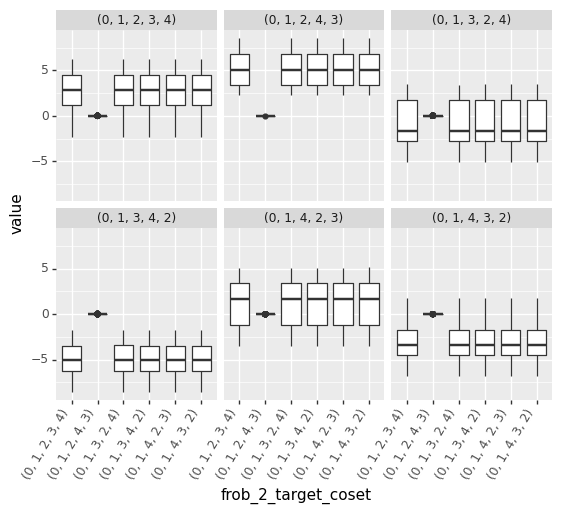

<ggplot: (710734041)>

In [193]:
target_right = (
    dim0_df
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_right_coset'})
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_target', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_target_coset'})
)


left_right_pos = (
    dim0_df
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_right_coset'})
    .join(frob_cosets.select(['permutation', 'coset_rep_1']), left_on='permutation_left', right_on='permutation', how='inner')
    .rename({'coset_rep_1': 'frob_1_left_coset'})
)

left_right_neg = (
    dim0_df
    .join(frob_cosets.select(['permutation', 'coset_rep_2']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_2': 'frob_2_right_coset'})
    .join(frob_cosets.select(['permutation', 'coset_rep_0']), left_on='permutation_left', right_on='permutation', how='inner')
    .rename({'coset_rep_0': 'frob_0_left_coset'})

)
"""
(
    left_right.groupby(
        ['frob_2_right_coset', 'frob_2_target_coset']
    )
    .agg([
        pl.col('value').min().alias('min_value'), 
        pl.col('value').mean().alias('mean_value'), 
        pl.col('value').max().alias('max_value')]
    )
    .sort(['mean_value'])
)
"""

ggplot(target_right, aes(x="frob_2_target_coset", y='value')) + geom_boxplot() + facet_wrap('~frob_2_right_coset') + theme(axis_text_x=element_text(rotation=60, hjust=1))



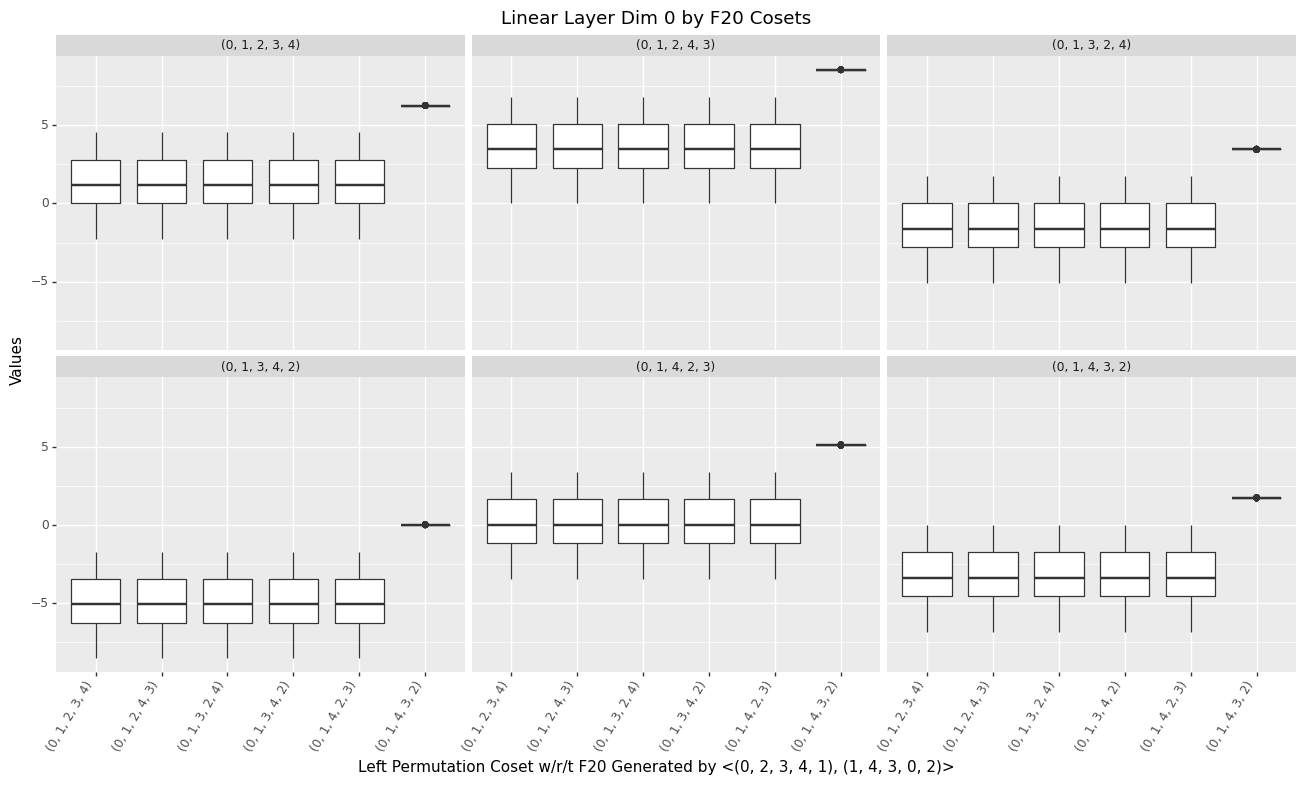

<ggplot: (709203047)>

In [205]:
from plotnine import labs

(
    ggplot(
        left_right_pos, 
        aes(x="frob_1_left_coset", y='value')
    ) 
    + geom_boxplot() 
    + facet_wrap('~frob_2_right_coset') 
    + theme(axis_text_x=element_text(rotation=60, hjust=1), figure_size=(16, 8))
    + labs(
        x='Left Permutation Coset w/r/t F20 Generated by <(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)>',
        y='Values',
        color='Right Permutation Coset w/r/t F20 Generated by <(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)>'
    )
    + ggtitle('Linear Layer Dim 0 by F20 Cosets')
)
    


In [218]:
dim2_df = (
    linear_acts_df
    .select(pl.all().exclude('in_train'))
    .select(pl.all().exclude('^index.*$'))
    #.join(frob_cosets.melt(id_vars='permutation', variable_name='coset', value_name='coset_rep'), left_on='permutation_target', right_on='permutation' , how='inner')
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .filter(pl.col('variable') == 'dim2')
    #.select(pl.all().exclude('variable'))
    #.filter(pl.col('value') >= 0)
    #.with_columns((pl.col('value') * (pl.col('value') > 0.).cast(pl.Float32)).alias('relu_value'))
    #.groupby('permutation_target')
    #.agg([
    #    pl.col('value').min().alias('min_value'),
    #    pl.col('value').mean().alias('mean_value'),
    #    pl.col('value').std().alias('std_value'),
    #    pl.col('value').max().alias('max_value')
    #
    #])
    #.filter(pl.col('value').abs() > 8.5)
    .sort(['value'])
)
#dim2_df.filter(pl.col('value').abs() > 8.).groupby('permutation_right').agg([pl.count(), pl.col('value').mean()]).sort('value')

In [319]:
rperms = (
    dim2_df
    .filter(pl.col('value') > 8)['permutation_right'].unique().sort().to_list()
)

rperms

['(0, 1, 2, 4, 3)',
 '(0, 1, 3, 4, 2)',
 '(0, 2, 1, 4, 3)',
 '(0, 2, 3, 4, 1)',
 '(0, 3, 1, 4, 2)',
 '(0, 3, 2, 4, 1)',
 '(1, 0, 2, 4, 3)',
 '(1, 0, 3, 4, 2)',
 '(1, 2, 0, 4, 3)',
 '(1, 2, 3, 4, 0)',
 '(1, 3, 0, 4, 2)',
 '(1, 3, 2, 4, 0)',
 '(2, 0, 1, 4, 3)',
 '(2, 0, 3, 4, 1)',
 '(2, 1, 0, 4, 3)',
 '(2, 1, 3, 4, 0)',
 '(2, 3, 0, 4, 1)',
 '(2, 3, 1, 4, 0)',
 '(3, 0, 1, 4, 2)',
 '(3, 0, 2, 4, 1)',
 '(3, 1, 0, 4, 2)',
 '(3, 1, 2, 4, 0)',
 '(3, 2, 0, 4, 1)',
 '(3, 2, 1, 4, 0)']

In [342]:
lperms = (
    dim2_df
    .filter(pl.col('permutation_target') == "(4, 3, 1, 0, 2)")
    .sort('value').filter(pl.col('value').abs() > 8.)['permutation_left'].sort().to_list()
)
rperms = (
    dim2_df
    .filter(pl.col('value') < -8)['permutation_right'].unique().sort().to_list()
)



lperms = tuple([eval(p) for p in lperms])
rperms = tuple([eval(p) for p in rperms])

    
    

rperms


((0, 1, 2, 3, 4),
 (0, 1, 3, 2, 4),
 (0, 2, 1, 3, 4),
 (0, 2, 3, 1, 4),
 (0, 3, 1, 2, 4),
 (0, 3, 2, 1, 4),
 (1, 0, 2, 3, 4),
 (1, 0, 3, 2, 4),
 (1, 2, 0, 3, 4),
 (1, 2, 3, 0, 4),
 (1, 3, 0, 2, 4),
 (1, 3, 2, 0, 4),
 (2, 0, 1, 3, 4),
 (2, 0, 3, 1, 4),
 (2, 1, 0, 3, 4),
 (2, 1, 3, 0, 4),
 (2, 3, 0, 1, 4),
 (2, 3, 1, 0, 4),
 (3, 0, 1, 2, 4),
 (3, 0, 2, 1, 4),
 (3, 1, 0, 2, 4),
 (3, 1, 2, 0, 4),
 (3, 2, 0, 1, 4),
 (3, 2, 1, 0, 4))

In [343]:
def ltrans(element, perms):
    all_perms = [Permutation(p) for p in perms]
    g = all_perms[element].inverse
    return sorted([(g * p).sigma for p in all_perms])

lg = ltrans(0, rperms)

In [344]:
lg

[(0, 1, 2, 3, 4),
 (0, 1, 3, 2, 4),
 (0, 2, 1, 3, 4),
 (0, 2, 3, 1, 4),
 (0, 3, 1, 2, 4),
 (0, 3, 2, 1, 4),
 (1, 0, 2, 3, 4),
 (1, 0, 3, 2, 4),
 (1, 2, 0, 3, 4),
 (1, 2, 3, 0, 4),
 (1, 3, 0, 2, 4),
 (1, 3, 2, 0, 4),
 (2, 0, 1, 3, 4),
 (2, 0, 3, 1, 4),
 (2, 1, 0, 3, 4),
 (2, 1, 3, 0, 4),
 (2, 3, 0, 1, 4),
 (2, 3, 1, 0, 4),
 (3, 0, 1, 2, 4),
 (3, 0, 2, 1, 4),
 (3, 1, 0, 2, 4),
 (3, 1, 2, 0, 4),
 (3, 2, 0, 1, 4),
 (3, 2, 1, 0, 4)]

In [341]:
sorted(generate_subgroup(s4_subgroups['generators'][4])) == lg


True

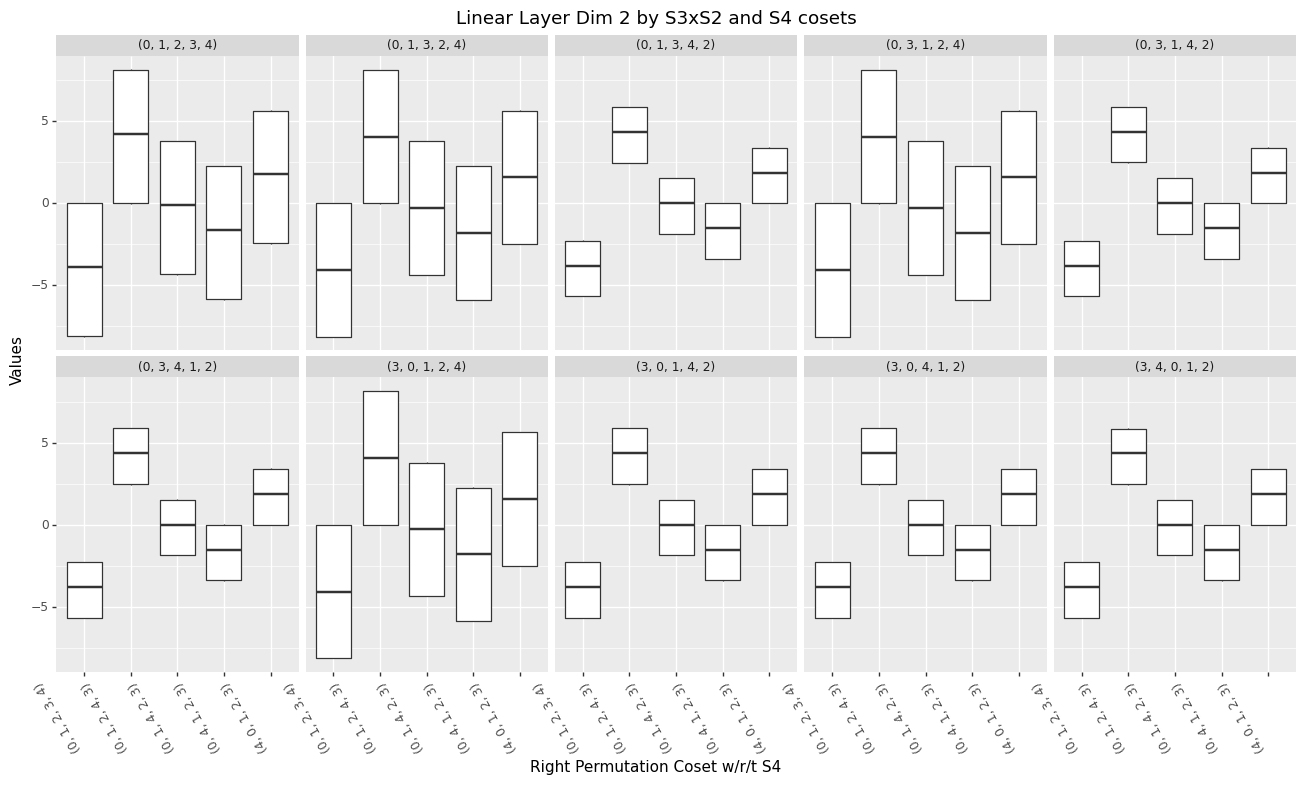

<ggplot: (709329939)>

In [336]:
df = (
    dim2_df
    .join(s4_cosets.select(['permutation', 'coset_rep_4']), left_on='permutation_right', right_on='permutation', how='inner')
    .rename({'coset_rep_4': 'S4_right_coset'})
    .join(s3xs2_cosets.select(['permutation', 'coset_rep_9']), left_on='permutation_left', right_on='permutation', how='inner')
    .rename({'coset_rep_9': 'S3xS2_left_coset'})
)

(
    ggplot(df, aes(x='S4_right_coset', y='value')) 
    + geom_boxplot() + facet_wrap('~S3xS2_left_coset', ncol=5) 
    + theme(axis_text_x=element_text(rotation=120, hjust=1), figure_size=(16, 8))
    + labs(
        x='Right Permutation Coset w/r/t S4',
        y='Values'
    )
    + ggtitle('Linear Layer Dim 2 by S3xS2 and S4 cosets')
)

In [131]:
#dim0_df.groupby('permutation_target').agg(
#    [
#        pl.count(),
#        (pl.col('value') > 0).sum().alias('num_gt_zero')
#    ]
#)


for lp, rp, val in dim0_df.filter(pl.col('permutation_target') == "(1, 4, 0, 2, 3)").sort('value').select(['permutation_left', 'permutation_right', 'value']).rows():
    lperm = Permutation(eval(lp))
    rperm = Permutation(eval(rp))
    print(f'{lperm.parity} * {rperm.parity} : {val}')

0 * 0 : -8.543586730957031
1 * 1 : -8.543251037597656
1 * 1 : -8.542061805725098
0 * 0 : -8.541313171386719
1 * 1 : 8.542131423950195
1 * 1 : 8.543261528015137
0 * 0 : 8.54463005065918
0 * 0 : 8.57685375213623


In [125]:
lperm0 = Permutation((1, 2, 4, 0, 3))
rperm0 = Permutation((2, 1, 4, 3, 0))

rperm0.conjugacy_class

(3, 1, 1)

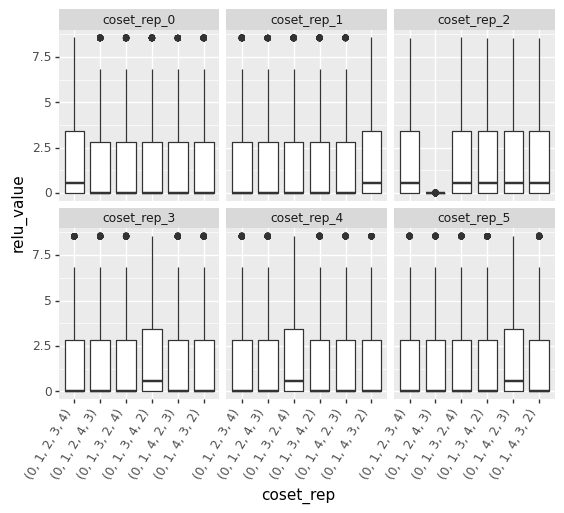

<ggplot: (671995277)>

In [51]:
from plotnine import geom_boxplot, geom_jitter

df = (
    linear_acts_df
    .select(pl.all().exclude('in_train'))
    .select(pl.all().exclude('^index.*$'))
    .join(frob_cosets.melt(id_vars='permutation', variable_name='coset', value_name='coset_rep'), left_on='permutation_target', right_on='permutation' , how='inner')
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset', 'coset_rep'])
    .filter(pl.col('variable') == 'dim0')
    #.select(pl.all().exclude('variable'))
    #.filter(pl.col('value') >= 0)
    .with_columns((pl.col('value') * (pl.col('value') > 0.).cast(pl.Float32)).alias('relu_value'))
    
    #.melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'], value_vars='value')
)
ggplot(df, aes(x = 'coset_rep', y='relu_value')) + geom_boxplot() + facet_wrap('~coset') +theme(axis_text_x=element_text(rotation=60, hjust=1))

In [52]:
target_sort_idx = torch.argsort(targets, stable=True)
linear_means = linear_acts[target_sort_idx].reshape((120, 120, 128)).sum(dim=1)
linear_means

tensor([[ 0.1071, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1071, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0221],
        [ 0.1071, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        ...,
        [ 0.1071, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1071, -1.0575,  0.8977,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1071, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222]])

In [55]:
from itertools import product

def slow_convolve(left_lin, right_lin, dim=128):
    S5 = Permutation.full_group(5)
    index = {perm.sigma: i for i, perm in enumerate(S5)}
    target = {perm.sigma: torch.zeros(128) for perm in S5}
    for lperm in S5:
        target_idx = index[lperm.sigma]
        for rperm in S5:
            lidx = index[(lperm * rperm.inverse).sigma]
            ridx = index[rperm.sigma]
            lval, rval = left_lin[lidx], right_lin[ridx]
            target[lperm.sigma] += lval + rval
    return torch.stack([target[p.sigma] for p in S5])
        

slow_convolve((model.lembed.weight @ W[:, :256].T), model.rembed.weight @ W[:, 256:].T)

tensor([[ 0.1070, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1070, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1070, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        ...,
        [ 0.1070, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1070, -1.0575,  0.8978,  ..., -0.1632,  0.1114,  0.0222],
        [ 0.1070, -1.0575,  0.8977,  ..., -0.1632,  0.1114,  0.0222]],
       grad_fn=<StackBackward0>)

In [86]:
(model.lembed.weight @ W[:, :256].T)

tensor([[-4.3634, -3.1092,  3.9651,  ...,  1.4061,  2.1672, -0.2300],
        [ 0.7278, -2.7927,  0.1793,  ..., -1.5294, -1.6690,  4.4043],
        [ 2.4600, -1.3680, -4.1774,  ...,  0.8399, -0.6516, -4.1573],
        ...,
        [ 0.7367, -1.0291,  0.1835,  ..., -0.8974, -1.6739,  1.7541],
        [-0.9102,  2.5484, -1.6856,  ...,  1.4260,  0.6381, -1.7671],
        [-2.0771, -1.5463,  1.7083,  ...,  1.0043,  2.4372, -0.2318]],
       grad_fn=<MmBackward0>)

In [104]:
def convolve(f, g, dim):
    assert len(f) == len(g)
    group = Permutation.full_group(dim)
    output = {perm.sigma: 0. for perm in group}
    for fval, fperm in zip(f, group):
        for gval, gperm in zip(g, group):
            prod = (fperm * gperm).sigma
            output[prod] += fval * gval
    return np.array([output[perm.sigma].detach() for perm in group])

convolve((model.lembed.weight @ W[:, :256].T)[0, :], (model.rembed.weight @ W[:, 256:].T)[0, :], 5)

array([ 3.1749475e+01,  2.1411470e+01,  2.2901546e+01, -5.0405193e+01,
        3.9620399e+01,  5.8112000e+01, -2.4819665e+00, -4.0191383e+01,
        5.3654255e+01, -7.2978621e+00, -6.2769112e+01, -5.0708252e+01,
       -3.9672194e+00, -6.1115173e+01,  4.4768833e+01, -1.2426219e+01,
        4.3991375e+01,  9.1226364e+01, -8.9698875e+01, -9.6408485e+01,
        1.6336620e+02,  4.4798369e+00, -5.2123581e+01, -7.0255127e+01,
        6.8826847e+00, -8.3304268e+01, -4.4902067e+00,  9.0285950e+01,
        3.8798706e+01, -3.6068811e+00,  1.0185442e+01,  3.1971001e+01,
        6.4207497e+01,  1.0389948e+01, -2.9266970e+01, -5.1225346e+01,
       -4.9530670e+01,  2.8675732e+01,  5.4245785e+01,  1.1562693e+01,
       -1.8915312e+01, -4.5953037e+01, -2.3477217e+01, -1.6149710e+01,
       -4.0137100e+01, -5.1106224e+01,  2.1910677e+01, -3.5196381e+01,
       -2.7107342e+01,  2.6403521e+01, -3.2209957e+01,  1.0389868e+02,
        7.7180057e+00, -3.9021179e+01,  3.1153568e+01, -6.3599125e+01,
      

In [101]:

def ft_convolve(f, g):
    out = {}
    for key, m1 in f.items():
        m2 = g[key]
        if m1.dim() == 1:
            prod = m1 * m2
        else:
            prod = torch.bmm(m1, m2)
        out[key] = prod
    return out


llin_ft = slow_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)

lin_ft_conv = ft_convolve(llin_ft, rlin_ft)
lin_ft_basis = sn_fourier_basis(lin_ft_conv, 5)

lin_ft_basis.sum(dim=1)[:, 0]

tensor([ 192.6456,  192.7127,  193.0547,  193.0879,  193.0555, -964.6473,
        -964.6475,  193.1439,  192.9776,  193.1431,  192.7127,  192.7558,
         193.0549,  192.5751,  192.7832,  193.0597,  192.8395,  192.5750,
        -964.6476,  193.1152,  193.0603,  193.1714, -964.6475,  193.0555,
         193.0830, -964.6475,  193.0603,  192.6456,  193.0598,  192.7689,
         192.7689,  193.0870,  192.7509,  193.0876, -964.6475,  192.9776,
         192.9502, -964.6474,  193.1715,  193.0875,  193.0880, -964.6475,
         192.6805,  192.8394,  193.0869,  192.7559,  192.6805,  192.9494,
         192.7832,  192.6854,  193.1432,  193.0831,  193.1438, -964.6475,
        -964.6473,  192.9501,  193.1152,  192.9495,  192.6855,  192.7510,
        -964.6475,  193.1714,  193.0603,  192.7127,  192.9492,  192.8393,
         192.7510,  193.0598,  192.7127,  192.9500,  193.0830, -964.6474,
         193.1438,  193.0879, -964.6475,  193.0876, -964.6475,  193.0831,
         192.7510,  192.5751,  193.143

In [76]:
print(llin_ft[(3, 2)][0])

tensor([[ 1.8126e+01,  4.2116e+01,  5.3437e+00, -2.2158e+01, -4.4839e+01],
        [-2.5659e+01, -5.9546e+01, -7.5371e+00,  3.1333e+01,  6.3402e+01],
        [-1.9494e-02, -1.4973e-02, -3.4372e-02,  5.1889e-03,  4.8669e-02],
        [-1.3858e-02,  6.9698e-03, -1.0707e-03,  2.2813e-02, -5.7821e-03],
        [ 2.5626e+01,  5.9521e+01,  7.4872e+00, -3.1327e+01, -6.3413e+01]],
       grad_fn=<SelectBackward0>)


In [77]:
print(llin_ft[(3, 2)][0] @ rlin_ft[(3, 2)][0])

tensor([[ 4.6303e+03,  3.2758e+03,  5.6722e+03, -5.6722e+03,  3.2746e+03],
        [-6.5474e+03, -4.6321e+03, -8.0206e+03,  8.0207e+03, -4.6303e+03],
        [-3.4627e+00, -2.4497e+00, -4.2419e+00,  4.2420e+00, -2.4489e+00],
        [-2.0976e-01, -1.4833e-01, -2.5683e-01,  2.5693e-01, -1.4845e-01],
        [ 6.5459e+03,  4.6310e+03,  8.0187e+03, -8.0188e+03,  4.6292e+03]],
       grad_fn=<MmBackward0>)


In [81]:
lin_ft_conv[(3, 2)][0]

tensor([[ 4.6303e+03,  3.2758e+03,  5.6722e+03, -5.6722e+03,  3.2746e+03],
        [-6.5474e+03, -4.6321e+03, -8.0206e+03,  8.0207e+03, -4.6303e+03],
        [-3.4627e+00, -2.4497e+00, -4.2419e+00,  4.2420e+00, -2.4489e+00],
        [-2.0976e-01, -1.4833e-01, -2.5683e-01,  2.5693e-01, -1.4845e-01],
        [ 6.5459e+03,  4.6310e+03,  8.0187e+03, -8.0188e+03,  4.6292e+03]],
       grad_fn=<SelectBackward0>)

In [82]:
conv_ft[(3, 2)][0]

tensor([[ 4.2975e-05, -8.9593e-05,  5.7794e-05,  1.4874e-04,  4.4636e-05],
        [-6.8724e-05,  1.1936e-04, -1.1757e-04, -1.8709e-04, -6.6988e-05],
        [-1.1861e-05, -7.5698e-06, -1.7963e-05,  1.2964e-05, -1.6879e-05],
        [-1.9073e-06,  8.4192e-07, -2.0318e-05,  1.1325e-05,  7.2680e-06],
        [ 5.7481e-05, -1.2982e-04,  8.6874e-05,  2.0941e-04,  4.9319e-05]])

In [208]:



def subgroup_check(df, dim, coset):
    var = f'dim{dim}'
    cos = f'coset_rep_{coset}'
    return (
        df.select(['permutation', 'irrep', 'variable', cos, 'value'])
        .filter(pl.col('variable') == var)
        #.filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .groupby(['irrep', cos])
        .agg([
            pl.col('value').mean().alias('coset_mean'),
            pl.col('value').std().alias('cost_std')
        ])
        .sort('coset_mean')
    )



def sanity_check(df, dim, coset):
    var = f'dim{dim}'
    cos = f'coset_rep_{coset}'
    return (
        df.select(['permutation', 'irrep', 'variable', cos, 'value'])
        .filter(pl.col('variable') == var)
        #.filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .groupby(cos)
        .agg([
            pl.col('value').sum().alias('coset_total'),
        ])
        .sort('coset_total')
    )

subgroup_check(s4_analysis, 2, 0)
#cos = f'coset_rep_frob_0'
#frob_analysis.select(['permutation', 'irrep', 'variable', cos]).head()

irrep,coset_rep_0,coset_mean,cost_std
str,str,f32,f32
"""(2, 1, 1, 1)""","""(1, 2, 0, 3, 4...",-0.489859,4.30197
"""(2, 1, 1, 1)""","""(0, 1, 2, 3, 4...",-0.488301,4.302893
"""(2, 1, 1, 1)""","""(1, 0, 2, 3, 4...",-0.48662,4.303888
"""(2, 1, 1, 1)""","""(1, 2, 3, 0, 4...",-0.482471,4.306315
"""(1, 1, 1, 1, 1...","""(1, 2, 3, 0, 4...",-0.000002,0.0
"""(1, 1, 1, 1, 1...","""(1, 2, 3, 4, 0...",-0.000002,0.0
"""(1, 1, 1, 1, 1...","""(1, 2, 0, 3, 4...",-0.000002,0.0
"""(1, 1, 1, 1, 1...","""(1, 0, 2, 3, 4...",-0.000002,0.0
"""(1, 1, 1, 1, 1...","""(0, 1, 2, 3, 4...",-0.000002,0.0


In [521]:
# (4, 1) : 105
# (3, 2) : 0

(
    conv_df
    .melt(id_vars=['permutation', 'irrep'])
    .filter(pl.col('variable') == 'dim0')
    .sort('value')
)

permutation,irrep,variable,value
str,str,str,f32
"""(1, 3, 0, 4, 2...","""(3, 2)""","""dim0""",-8.038726
"""(1, 4, 2, 3, 0...","""(3, 2)""","""dim0""",-8.038726
"""(0, 3, 1, 2, 4...","""(3, 2)""","""dim0""",-8.038725
"""(2, 0, 3, 4, 1...","""(3, 2)""","""dim0""",-8.038725
"""(2, 4, 1, 0, 3...","""(3, 2)""","""dim0""",-8.038725
"""(3, 0, 2, 1, 4...","""(3, 2)""","""dim0""",-8.038725
"""(3, 1, 4, 0, 2...","""(3, 2)""","""dim0""",-8.038725
"""(4, 1, 3, 2, 0...","""(3, 2)""","""dim0""",-8.038725
"""(0, 1, 2, 4, 3...","""(3, 2)""","""dim0""",-8.038725


In [342]:
rlin_ft = slow_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)
rlin_decomp = sn_fourier_basis(rlin_ft, 5)
rlin_df = fourier_basis_to_df(rlin_decomp, 5)
rlin_df.head(7)

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.001497,-0.006308,-0.000275,0.002008,-0.000764,-0.00125,-0.013021,0.001616,0.002004,-0.005798,0.022486,-0.002263,0.006964,0.01102,-0.002168,0.000208,0.004372,0.021148,-0.001548,0.001178,-0.004607,-0.012314,0.000607,0.002014,0.008383,0.001914,-0.022405,-0.009297,0.005034,0.001033,0.002115,-0.01395,0.012099,-0.003009,0.01326,...,0.008222,-0.007401,0.007083,-0.004073,0.010527,-0.000201,0.000004,0.010936,-0.007379,-0.000472,-0.000978,0.028801,0.0049,0.001786,-0.012703,0.024169,-0.006814,-0.007285,-0.004345,-0.003057,0.000905,-0.001363,-0.006637,-0.022088,-0.02407,0.00693,0.000295,-0.021118,0.003782,0.009981,0.001368,-0.010223,0.003607,-0.010103,-0.013617,0.012173,-0.000126
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-0.000309,0.002316,-3.97623,0.000807,0.001454,0.006703,0.022849,0.000341,-0.000293,0.031833,0.004875,0.023956,0.017196,0.132028,-0.052849,-4.617566,0.117847,-0.072071,-0.000231,1.867356,0.076089,0.01681,4.054132,0.000373,0.049749,0.000335,-0.058866,-0.04313,-0.048303,5.392576,-0.000239,-0.002984,0.007473,0.103144,0.170007,...,-0.030446,0.111313,-0.015794,0.011188,-0.010234,-5.34538,-1.798588,-0.00717,0.012393,0.039455,-0.000386,-0.009391,0.090705,0.000346,0.057458,-1.633777,-0.015934,0.05194,0.027435,0.012944,-0.018932,-0.000863,0.019185,-0.048137,-0.03858,-0.111435,-2.081245,0.016484,-0.116833,0.055245,0.000475,0.00029,-0.061935,-0.047405,-0.034482,0.0011,-1.755125
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.00131,-0.053153,0.002776,-0.000494,-0.130034,0.045356,-0.07219,-0.000277,-0.000622,-0.040184,0.007799,1.685278,0.092861,0.025033,-0.085713,0.001739,-0.016058,0.147151,0.000144,0.005338,-1.105093,0.037322,-0.002245,-0.000247,0.024007,-0.001532,0.052369,0.069546,0.001477,-0.005149,-0.000679,0.050089,0.0619,-1.713029,-0.109167,...,-0.088382,-1.462905,0.985281,-1.032556,0.034258,0.004479,-0.002982,1.986493,-0.117702,1.69401,-0.001153,-0.135565,-0.110974,0.001587,0.04688,0.007096,0.043628,0.028071,-1.036051,0.037873,1.138945,-0.00029,0.001319,0.068745,0.064668,0.129634,0.00148,-0.165982,1.59064,0.054418,0.000283,-0.002036,0.01356,-0.020734,-0.960173,0.000902,0.000969
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.000394,-0.097624,-0.001854,-0.000567,-0.162616,-0.007224,0.024301,0.000732,-0.000721,-0.113632,0.087881,-0.014254,-0.126955,0.116004,-0.0418,0.00168,0.095989,0.096495,0.000029,-0.005702,0.024334,-0.068157,-0.000835,-0.000044,0.076533,0.000414,0.010417,0.040966,-0.045246,-0.000536,0.000291,-0.074751,0.013771,-0.045452,-0.074446,...,-0.021605,-0.034217,-0.034209,0.027278,0.037382,0.000592,0.008313,0.038033,-0.112987,-0.007003,0.001043,0.090652,0.034507,-0.000591,-0.090155,0.002216,-0.076591,-0.039896,0.017037,0.001561,-0.04554,0.001249,-0.118856,0.043269,0.020724,0.114592,-0.003688,-0.062224,0.030465,0.020358,0.000275,-0.001029,-0.033439,0.118343,-0.02193,0.002332,-0.000801
"""(0, 1, 2, 3, 4...","""(3, 2)""",2.07827,0.041134,-0.001475,2.321342,0.098894,0.059108,0.058027,-3.924206,2.347076,-0.008056,-0.066544,0.001227,0.131025,-0.227154,0.057105,-0.003312,0.087465,-0.08617,-2.261263,0.008941,-0.000891,0.048411,0.003926,2.37413,0.048765,-1.611509,-0.059533,-0.020657,0.091766,0.00347,-2.162757,0.039159,0.042406,0.004966,-0.125

In [129]:
data, lembed_ft, rembed_ft = embedding_harmonic_analysis(full_run)

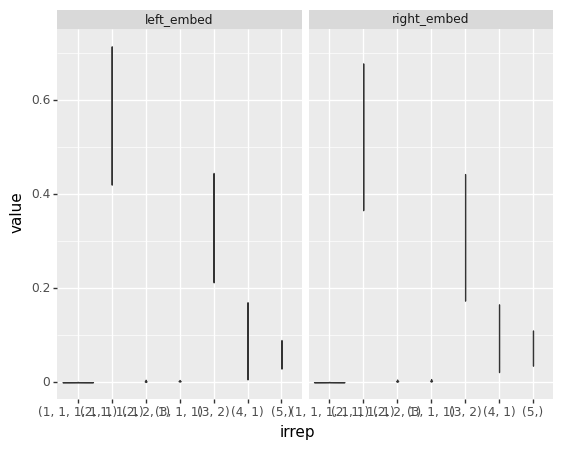

<ggplot: (393197881)>

In [13]:
ggplot(
    data.select(pl.all().exclude('epoch')).melt(id_vars=['layer', 'irrep']),
    aes(x='irrep', y='value')
) + geom_violin() + facet_wrap('~layer')

In [14]:
def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')

In [15]:
lembed_fb = sn_fourier_basis(lembed_ft, 5, 'cpu')
lembed_decomp_data = fourier_basis_to_df(lembed_fb, 5)
lembed_decomp_data.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",0.001456,-0.001593,-0.000347,-0.000254,-0.003013,-0.000814,0.00125,-0.002631,0.000628,0.000778,-0.00187,0.000336,0.000028,-0.000941,-0.000677,-0.001862,-0.000894,-0.002457,0.002177,0.000426,-0.001166,-0.000311,0.001553,-0.001276,-0.000883,-0.003152,0.002285,-0.000738,0.000739,0.00194,0.001124,-0.002158,0.002108,-0.000894,-0.000668,...,-0.001481,-0.000235,0.000851,-0.00216,0.002083,0.001104,-0.001419,0.001354,0.001827,-0.00004,-0.001711,0.001541,0.001361,0.002003,-0.000459,-0.000572,0.003451,0.004278,0.001287,0.00101,-0.000131,-0.000868,-0.001432,0.001533,-0.001557,-0.001655,0.000866,-0.000757,-0.001279,0.001694,-0.00078,-0.002118,0.00324,-0.000463,-0.000247,0.000786,-0.000383
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-0.2098,0.018477,-0.152431,-0.122107,-0.052221,0.26042,0.18537,0.19373,-0.03995,-0.008018,0.166323,0.108085,0.030409,0.18533,0.105232,-0.256142,-0.106182,-0.103479,0.105741,0.128351,-0.033784,-0.145484,0.178296,-0.049778,-0.060233,0.248811,-0.077295,-0.187402,-0.068822,-0.070011,0.151243,-0.177036,-0.211215,0.050017,-0.005622,...,-0.002622,-0.270248,0.102476,-0.130795,-0.054312,-0.054655,-0.269603,0.024855,-0.222303,0.287893,-0.089961,-0.219333,0.017259,-0.066773,0.272209,0.222045,0.108122,-0.196296,0.08795,-0.118535,-0.064739,0.002713,-0.224301,0.285655,0.043084,0.07818,-0.060628,-0.037348,-0.051984,-0.036236,0.176389,0.005186,0.016377,-0.201187,-0.027048,-0.233526,0.000568
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",-0.011886,-0.002585,-0.000274,-0.004529,-0.003555,-0.012594,-0.006284,-0.003186,-0.012201,-0.005911,-0.012526,0.002004,0.00157,-0.004171,0.011154,-0.000765,0.000716,-0.01654,0.005401,-0.002887,0.013133,-0.004055,-0.002414,-0.003892,-0.005011,-0.013429,0.004758,0.0068,-0.002511,0.001278,-0.005894,0.005884,0.01028,-0.020968,-0.009252,...,-0.007901,0.010201,0.000365,0.006029,-0.006464,-0.011786,-0.015695,0.003947,0.010994,-0.006041,0.008496,0.004502,-0.001491,0.001768,-0.021542,0.01316,0.003839,0.010931,0.001444,0.007135,0.008965,-0.002533,-0.000204,0.003143,-0.001678,0.000991,-0.00393,-0.007373,0.012698,-0.003843,0.009987,0.003753,0.007779,-0.000974,0.003104,-0.00236,-0.016287
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.009601,-0.000833,0.010149,-0.000331,0.000935,-0.017142,0.026923,-0.006192,-0.012232,-0.004052,0.017485,0.003419,0.005785,0.010996,-0.000685,-0.008797,-0.01188,-0.005187,0.015429,0.010395,0.005005,0.005738,0.002209,-0.000961,-0.002275,-0.016989,-0.005007,0.018024,-0.004047,-0.01445,0.011954,-0.01457,0.00185,0.004163,-0.004756,...,0.021525,0.027026,0.006323,0.000582,-0.007824,-0.011752,-0.010124,0.008328,0.011113,0.020769,-0.013887,0.018628,-0.010318,-0.004582,-0.001683,-0.00365,0.020134,-0.002783,0.00836,0.002084,-0.0061,-0.000221,0.004502,0.004226,-0.008066,0.005891,-0.006272,0.013551,-0.011524,0.010537,-0.00523,-0.017226,-0.001717,0.011728,-0.002159,0.001839,-0.009203
"""(0, 1, 2, 3, 4...","""(3, 2)""",0.199559,-0.086935,-0.088917,-0.049205,-0.015771,0.179394,-0.048641,-0.052362,-0.086705,0.001718,-0.214936,-0.059627,0.060588,-0.130624,-0.182958,0.038923,0.025126,-0.083972,0.045127,-0.003533,0.14935,-0.189578,-0.049774,0.030663,0.188203,0.133825,-0.199572,-0.101368,-0.223962,-0.101458,-0

In [19]:


def make_coset_rep_df(cosets):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)

f1_df = make_coset_rep_df(list(f1_cosets))

In [26]:
f2_df = make_coset_rep_df(list(f2_cosets))

In [ ]:
(
    lembed_decomp_data
    .join(f2_df, on='permutation', how='inner')
    .filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .select(pl.all().exclude(['permutation']))
    .melt(id_vars=['coset_rep', 'irrep'])
    .groupby(['coset_rep', 'irrep'])
    .agg([
        pl.col('value').mean().alias('mean_value'),
        pl.col('value').median().alias('median_value'),
        pl.col('value').min().alias('min_value'),
        pl.col('value').max().alias('max_value')
    
    ])
    .sort(['irrep', 'coset_rep'])
)

In [53]:
def fourier_basis_2d_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    perm_pairs = list(product(permutations, permutations))
    partition_pairs = list(product(partitions, partitions))
    assert len(perm_pairs) == group_order, f'{len(perm_pairs)} != {group_order}'
    assert len(partition_pairs) == num_irreps, f'{len(partition_pairs)} != {num_irreps}'
    
    lparts, rparts = zip(*[(str(p1), str(p2)) for p1, p2 in partition_pairs])
    lperm_col, rperm_col, target_col = [], [], []
    lpart_col, rpart_col = [], []
    
    for perm1, perm2 in perm_pairs:
        lpart_col.extend(lparts)
        rpart_col.extend(rparts)
        lperm_col.extend([str(perm1.sigma)] * num_irreps)
        rperm_col.extend([str(perm2.sigma)] * num_irreps)
        target_col.extend([str((perm1 * perm2).sigma)] * num_irreps)
        
    long_values = tensor.reshape((-1, fn_dim))
    #group_col= []
    #for s in permutations:
    #    group_col += [str(s.sigma)] * num_irreps
    #part_col = [str(p) for p in all_partitions] * group_order
    assert len(lperm_col) == len(rperm_col)
    assert len(lperm_col) == len(lpart_col)
    assert len(lpart_col) == len(rpart_col)
    assert len(lpart_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({
        'permutation_left': lperm_col,
        'permutation_right': rperm_col,
        'permutation_product': target_col,
        'irrep_left': lpart_col,
        'irrep_right': rpart_col
    })
    return pl.concat([sn_metadata, val_data], how='horizontal')



def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs

In [54]:

from torch.nn.functional import relu

def linear_ft_decomp_data(model_seed, data_seed, checkpoint_dir):
    run = f'model_{model_seed}_data_{data_seed}'
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    data = pl.read_parquet(checkpoint_dir / f'data_{data_seed}.parquet')
    mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
    lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    
    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])
    out, cache = model.run_with_cache(lperms, rperms)
    linear_acts = relu(cache['hook_linear'].to(torch.float32))
    fourier_transform = slow_ft_2d(linear_acts, 5)
    fourier_decomp = sn_fourier_basis_2d(fourier_transform, 5, 'cpu')
    return fourier_basis_2d_to_df(fourier_decomp, 5)



In [55]:
model_seed = 0
data_seed = 15
exp_dir = Path('experiments')
data = linear_ft_decomp_data(model_seed, data_seed, exp_dir)

In [56]:
data.head()

permutation_left,permutation_right,permutation_product,irrep_left,irrep_right,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(1, 1, 1, 1, 1...",2.351655,1.826991,1.595498,2.364125,0.611856,0.534676,2.139711,2.522276,2.478679,0.934547,1.596236,2.39982,1.024975,0.000699,1.809303,0.624682,0.59246,0.991216,1.448445,1.575476,0.000681,1.532962,1.362769,2.246861,2.586046,0.561768,0.000884,2.157856,0.000605,1.141463,0.001033,0.001118,...,2.51619,0.739704,2.635862,1.030409,1.420247,1.716098,2.335865,2.19182,2.381964,1.800799,0.577671,2.075008,0.000283,0.568691,0.576655,2.299609,0.700349,1.475429,1.369232,0.7389,0.000855,1.508894,0.000333,1.327354,0.536821,0.001278,0.536752,2.334485,2.484315,0.629266,1.385547,0.962223,0.000468,1.559784,2.454764,0.923846,0.000651
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(2, 1, 1, 1)""",-2.351465,0.000143,0.001744,-0.522214,-0.048843,0.007689,3.248804,-0.748861,-0.735977,-0.001924,0.002839,-1.747911,-1.01693,0.000015,-1.810589,-0.030492,0.037248,0.182447,-0.002625,0.002826,0.00002,0.000568,1.995004,3.41015,1.186568,-0.096603,0.000235,3.39061,-0.000227,0.012937,-0.000123,-0.000395,...,1.150854,-0.021461,1.208105,-1.03013,0.000131,-0.000377,-1.701024,0.921444,-0.526213,-1.80208,0.041692,0.003591,-0.000036,-0.018977,-0.013635,-0.507564,-0.017729,0.80499,-0.002042,0.044021,0.000226,-0.000435,0.000015,-1.027564,-0.006495,-0.000152,0.033354,-1.700224,1.135226,0.195138,0.000896,-0.002816,-0.000245,0.002007,-2.456132,0.005427,0.00019
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(2, 2, 1)""",0.001451,-0.00041,-0.000704,-0.000097,-0.029127,-0.010321,-0.007129,-0.000461,0.000476,0.018468,0.000366,-0.00721,0.005326,-0.000369,0.004592,0.016677,0.010321,-0.000661,0.000317,0.000147,-0.00047,-0.000271,-0.029272,-0.006557,0.00366,0.040735,-0.000398,-0.001241,0.000054,0.007911,0.000504,-0.000003,...,0.002315,0.043909,0.003456,0.006344,-0.000694,0.000513,-0.007053,0.008756,-0.000642,0.004562,0.008428,0.019657,-0.000073,0.031984,0.008064,-0.000851,-0.069622,0.017261,0.000236,0.00573,-0.000369,-0.000277,-0.000219,-0.002328,-0.053991,-0.000718,-0.003809,-0.007377,0.002673,0.023087,0.001355,-0.064673,-0.000062,-0.000349,0.005805,0.007389,0.000275
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(3, 1, 1)""",-0.001246,0.000504,0.005473,-0.001638,0.007772,0.005732,0.000127,0.000057,-0.000546,-0.019709,0.006414,-0.000564,0.002344,0.000085,0.000357,-0.001665,0.02663,-0.021117,-0.005263,0.006371,0.000014,0.000379,0.000686,-0.000194,-0.00231,-0.001789,0.000035,0.001363,0.000017,0.005049,-0.000539,-0.000133,...,-0.00005,-0.002556,-0.001567,0.002382,0.000421,-0.000403,-0.00086,0.000285,-0.000181,0.000363,0.018419,-0.013691,0.00002,-0.000356,-0.000768,-0.001491,-0.027413,-0.052337,-0.005277,-0.037416,0.000043,-0.000024,0.000008,-0.008327,-0.015123,0.000334,-0.024017,-0.000552,-0.001298,-0.043689,0.001008,-0.010923,0.000012,0.004976,0.001017,0.000284,0.000028
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(3, 2)""",-0.000237,2.685801,-0.725739,0.001378,-0.020995,0.045328,0.004585,0.000493,0.000

In [57]:
(data
   # .filter(
   #     (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
        #& ((pl.col('irrep_left') == rep[0]) & (pl.col('irrep_right') == rep[1])))
 .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_product', 'irrep_left', 'irrep_right'])
    .groupby(['irrep_left', 'irrep_right'])
    .agg([
        pl.col('value').abs().mean().alias('mean_abs'),
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').max().alias('max').alias('max')
    ])
 .filter(
     (pl.col('min') < -0.5) | (pl.col('max') > 0.5)
 )
)

irrep_left,irrep_right,mean_abs,min,quantile_10,quantile_25,quantile_50,quantile_75,quantile_90,quantile_99,max
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(3, 2)""","""(3, 2)""",0.211065,-3.030951,-0.211439,-0.000381,-0.000002,0.000163,0.487175,1.481141,2.075473
"""(2, 1, 1, 1)""","""(2, 1, 1, 1)""",0.408447,-4.120929,-0.953817,-0.002444,0.000003,0.02745,0.88049,2.367716,2.641146
"""(1, 1, 1, 1, 1...","""(5,)""",0.050912,-2.052596,-0.063672,-0.0005,0.000003,0.000513,0.063672,0.121352,2.052596
"""(2, 1, 1, 1)""","""(1, 1, 1, 1, 1...",0.592913,-2.635963,-1.562067,-0.059945,-0.000078,0.000751,1.031102,3.83074,4.015679
"""(1, 1, 1, 1, 1...","""(2, 1, 1, 1)""",0.591683,-2.641275,-1.561461,-0.059304,-0.000097,0.009774,0.998387,3.884697,4.122308
"""(5,)""","""(1, 1, 1, 1, 1...",0.049729,-2.064037,-0.035356,-0.00008,3.3516e-10,0.00008,0.035356,0.117803,2.064037
"""(4, 1)""","""(1, 1, 1, 1, 1...",0.103014,-0.95956,-0.117822,-0.000279,0.000001,0.000285,0.12312,0.729787,0.958069
"""(1, 1, 1, 1, 1...","""(1, 1, 1, 1, 1...",1.270357,0.000276,0.000738,0.576655,1.420247,2.139711,2.409524,2.586046,2.635862
"""(4, 1)""","""(4, 1)""",0.080315,-1.10289,-0.051429,-0.00002,-3.4604e-9,0.00002,0.051368,0.649194,1.104055


In [100]:
frob = generate_subgroup(frobenius_groups['generators'][2])
cosets = get_cosets(frob)
frob_df = make_coset_rep_df(list(cosets))
(
    data
    .join(frob_df, left_on='permutation_product', right_on='permutation', how='inner')
    #.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .filter(
        ((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(3, 2)')) 
        #((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(1, 1, 1, 1, 1)')) |
        #((pl.col('irrep_left') == '(1, 1, 1, 1, 1)') & (pl.col('irrep_right') == '(3, 2)'))
    )
    .select(pl.all().exclude(['permutation_left', 'permutation_right']))
    .melt(id_vars=['coset_rep', 'irrep_left', 'irrep_right', 'permutation_product'])
    .groupby(['variable'])
    .agg([
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.01).alias('quantile_01'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').max().alias('max').alias('max')
    
    ])
    .sort(['max'])
    .tail(50)
)

variable,min,quantile_01,quantile_10,quantile_25,quantile_50,quantile_75,quantile_90,quantile_99,max
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""dim114""",-0.006923,-0.001874,-0.000932,-0.000452,0.000004,0.000456,0.00093,0.001842,0.008292
"""dim48""",-0.011071,-0.004411,-0.002103,-0.001071,4.4323e-7,0.001055,0.002132,0.004342,0.009313
"""dim12""",-0.007947,-0.001971,-0.001017,-0.000467,-7.0467e-7,0.000466,0.001017,0.001918,0.00956
"""dim61""",-0.009831,-0.003803,-0.001805,-0.00091,0.000004,0.000915,0.001833,0.003789,0.009807
"""dim101""",-0.009301,-0.003744,-0.001881,-0.000935,0.000013,0.000945,0.001839,0.003815,0.01236
"""dim4""",-0.01038,-0.005102,-0.002403,-0.00121,-0.000007,0.001195,0.002392,0.004993,0.012769
"""dim88""",-0.015976,-0.00681,-0.003235,-0.001576,0.000009,0.001603,0.003224,0.00671,0.013863
"""dim16""",-0.015272,-0.008252,-0.00405,-0.001978,0.000004,0.002001,0.004015,0.008323,0.014914
"""dim5""",-0.019309,-0.010229,-0.00492,-0.002433,-0.000009,0.002404,0.004862,0.010216,0.018122


In [110]:
frob = generate_subgroup(frobenius_groups['generators'][5])
cosets = get_cosets(frob)
frob_df = make_coset_rep_df(list(cosets))

( 
    data
    .join(frob_df, left_on='permutation_product', right_on='permutation', how='inner')
    #.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .filter(
        ((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(3, 2)')) 
        
        #((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(1, 1, 1, 1, 1)')) |
        #((pl.col('irrep_left') == '(1, 1, 1, 1, 1)') & (pl.col('irrep_right') == '(3, 2)'))
    )
    .melt(id_vars=['coset_rep', 'permutation_left', 'permutation_right', 'permutation_product', 'irrep_left', 'irrep_right'])
    .groupby(['variable', 'coset_rep'])
    .agg([
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.01).alias('quantile_01'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').max().alias('max').alias('max')
    
    ])
    .filter(pl.col('variable').is_in(['dim96']))
    .sort(['variable', 'coset_rep'])

)

variable,coset_rep,min,quantile_01,quantile_10,quantile_25,quantile_50,quantile_75,quantile_90,quantile_99,max
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""dim96""","""(0, 1, 2, 3, 4...",-1.261996,-1.261501,-1.208654,-0.339388,0.537544,1.135448,1.46337,1.716311,1.717353
"""dim96""","""(0, 1, 2, 4, 3...",-1.262094,-1.261617,-1.208763,-0.339427,0.537458,1.135379,1.4632,1.716256,1.717352
"""dim96""","""(0, 1, 3, 2, 4...",-2.847044,-2.846358,-2.845473,-2.522517,-1.514009,-0.937284,-0.93684,-0.936289,-0.935566
"""dim96""","""(0, 1, 3, 4, 2...",-1.261892,-1.261441,-1.208579,-0.339309,0.537531,1.135472,1.463354,1.716372,1.717348
"""dim96""","""(0, 1, 4, 2, 3...",-1.262199,-1.261623,-1.208656,-0.339527,0.537389,1.135432,1.463207,1.716204,1.717112
"""dim96""","""(0, 1, 4, 3, 2...",-1.261808,-1.261425,-1.208639,-0.339401,0.537647,1.135542,1.463391,1.716404,1.717298


In [128]:
(data
    .join(frob_df, left_on='permutation_product', right_on='permutation', how='inner')
    #.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)')
    .filter(
        ((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(3, 2)')) &
        (pl.col('coset_rep') == "(0, 1, 3, 2, 4)")
        
        #((pl.col('irrep_left') == '(3, 2)') & (pl.col('irrep_right') == '(1, 1, 1, 1, 1)')) |
        #((pl.col('irrep_left') == '(1, 1, 1, 1, 1)') & (pl.col('irrep_right') == '(3, 2)'))
    )
    .select(['permutation_left', 'permutation_right', 'permutation_product', 'dim96', 'irrep_left', 'irrep_right'])
    .filter(
        ((pl.col('dim96') < -1.53)) 
    )
    .select('permutation_right').unique().sort('permutation_right')
    #.join(
    #    data.select(['permutation_left', 'permutation_right', 'permutation_product', 'dim96', 'irrep_left', 'irrep_right']),
    #    on=['permutation_left', 'permutation_right'],
    #    how='inner'
    #)
    #.sort(['permutation_left', 'permutation_right', 'irrep_left', 'irrep_right'])
    #.filter(pl.col('dim96').abs() > 0.5)
)

permutation_right
str
"""(0, 1, 2, 3, 4..."
"""(0, 1, 2, 4, 3..."
"""(0, 1, 3, 4, 2..."
"""(0, 2, 1, 3, 4..."
"""(0, 2, 1, 4, 3..."
"""(0, 2, 4, 3, 1..."
"""(0, 3, 2, 1, 4..."
"""(0, 3, 4, 1, 2..."
"""(0, 3, 4, 2, 1..."


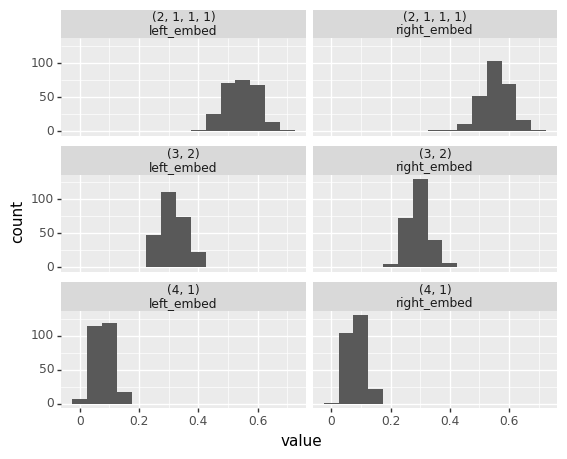

<ggplot: (687151264)>

In [134]:
ggplot(
    data.filter(pl.col('irrep').is_in(['(2, 1, 1, 1)', '(3, 2)', '(4, 1)'])).melt(id_vars=['epoch', 'layer', 'irrep']),
    aes(x='value')) + geom_histogram(binwidth=0.05) + facet_wrap('~irrep+layer', nrow=3)

In [135]:
melted = data.filter(pl.col('irrep').is_in(['(2, 1, 1, 1)', '(3, 2)', '(4, 1)'])).melt(id_vars=['epoch', 'layer', 'irrep'])
melted.head()

epoch,layer,irrep,variable,value
i64,str,str,str,f32
102841,"""left_embed""","""(2, 1, 1, 1)""","""dim0""",0.608633
102841,"""left_embed""","""(3, 2)""","""dim0""",0.273755
102841,"""left_embed""","""(4, 1)""","""dim0""",0.060549
102841,"""right_embed""","""(2, 1, 1, 1)""","""dim0""",0.468054
102841,"""right_embed""","""(3, 2)""","""dim0""",0.308295


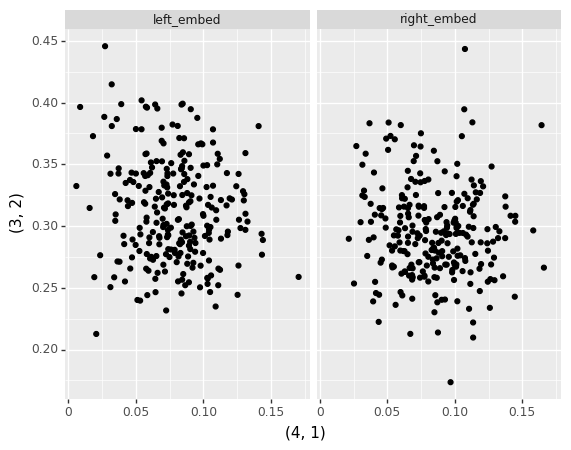

<ggplot: (687390096)>

In [145]:
(ggplot(
    melted.pivot(values='value', index=['variable', 'layer'], columns=['irrep']),
    aes(x='(4, 1)', y='(3, 2)')
) + geom_point() + facet_wrap('~layer')
)

In [148]:
melted.filter((pl.col('irrep') == '(3, 2)') & (pl.col('value') > 0.35)).sort(['layer', 'value']).filter(pl.col('layer') == 'left_embed')

epoch,layer,irrep,variable,value
i64,str,str,str,f32
102841,"""left_embed""","""(3, 2)""","""dim5""",0.350931
102841,"""left_embed""","""(3, 2)""","""dim90""",0.351516
102841,"""left_embed""","""(3, 2)""","""dim28""",0.352391
102841,"""left_embed""","""(3, 2)""","""dim236""",0.352537
102841,"""left_embed""","""(3, 2)""","""dim198""",0.352854
102841,"""left_embed""","""(3, 2)""","""dim49""",0.35437
102841,"""left_embed""","""(3, 2)""","""dim60""",0.35705
102841,"""left_embed""","""(3, 2)""","""dim157""",0.357726
102841,"""left_embed""","""(3, 2)""","""dim106""",0.358147


In [150]:
model = SnMLP.from_config(full_run['config'])
model.load_state_dict(full_run['model'])

<All keys matched successfully>

In [152]:
model.linear.weight.shape

torch.Size([128, 512])